In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
import sympy
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample
from utils import get_p3_from_p1

### Load precomputed integrals

In [2]:
lagrange_cubic_poisson_matrix = dill.load(
    open("../calculations/lagrange_cubic_poisson_matrix", "rb")
)
lagrange_cubic_poisson_right_values = dill.load(
    open("../calculations/lagrange_cubic_poisson_right_values", "rb")
)

### Initialize the domain

In [3]:
t = np.linspace(0, 2 * np.pi, 50, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [4]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.05neo1s")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edges = cndt["edges"]
edge_marker_is_boundary = cndt["edge_markers"]
print(f"Total number of points {points.shape[0]}")

Total number of points 114


## Make $P_{3}$ from $P_{1}$

In [5]:
points, triangles, vertex_marker_is_boundary = get_p3_from_p1(
    triangles, edges, points, vertex_marker_is_boundary, edge_marker_is_boundary
)

### Visualize the triangulation

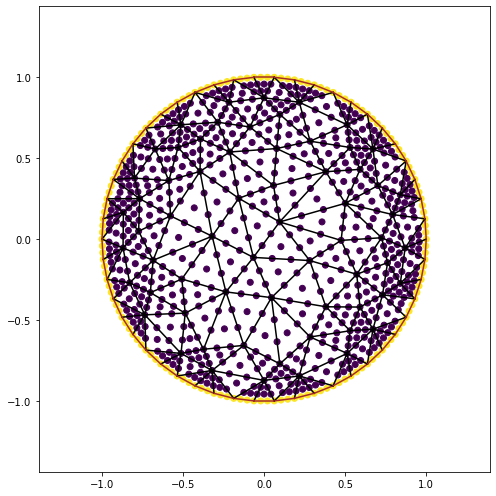

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )
    position = points[edge].mean(axis=0)

ax.scatter(*points.T, c=vertex_marker_is_boundary)

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [7]:
x, y = sympy.symbols("x y")

In [8]:
F = sympy.Float(1)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

In [9]:
matrix = np.zeros((points.shape[0], points.shape[0]))
b = np.zeros(points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    P_1_x = (-y1 + y3) / delta
    P_1_y = (+x1 - x3) / delta

    P_2_x = (+y1 - y2) / delta
    P_2_y = (-x1 + x2) / delta

    arg = [P_1_x, P_2_x, P_1_y, P_2_y, *right_vals[element]]

    FF = lagrange_cubic_poisson_matrix(*arg)
    ff = lagrange_cubic_poisson_right_values(*arg)

    for local_point in range(10):
        if vertex_marker_is_boundary[element[local_point]] == True:
            matrix[element[local_point], element[local_point]] = 1
            b[element[local_point]] *= 0
        else:
            for i in range(10):
                matrix[element[local_point], element[i]] += 2 * FF[local_point, i]

            b[element[local_point]] -= 2 * ff[local_point]

100%|██████████| 176/176 [00:00<00:00, 1009.09it/s]


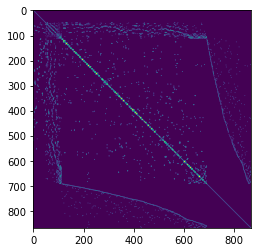

In [10]:
plt.imshow(matrix != 0)

In [11]:
F = np.linalg.solve(matrix, b)

In [12]:
_x_ = points[:, 0]
_y_ = points[:, 1]

In [13]:
U = -(1 - x**2 - y**2) / 4
U = sympy.lambdify((x, y), U)(*points.T)

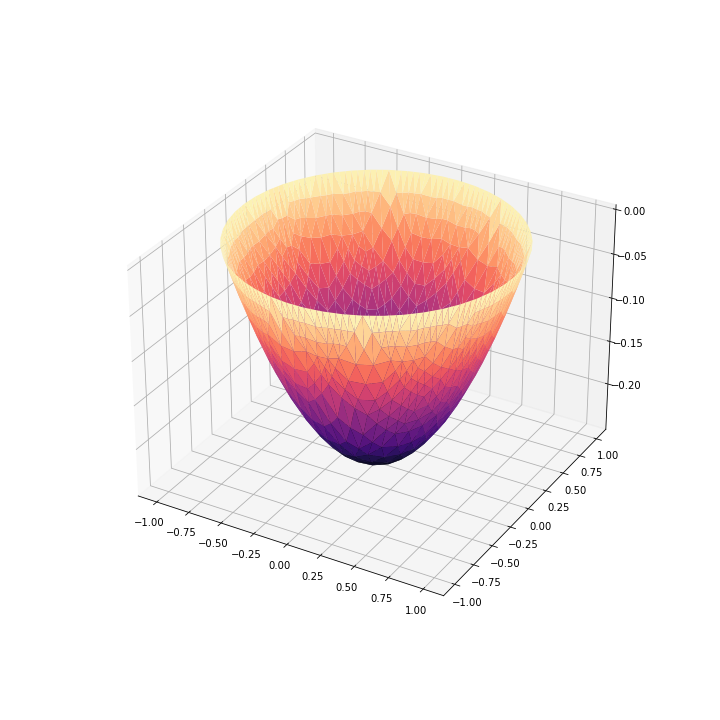

In [14]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_trisurf(points[:, 0], points[:, 1], F, cmap="magma", triangles=triangles)
plt.show()

### $ \lVert F - \hat{F} \rVert_{\infty}$

In [15]:
abs(U - F).max()

0.0008761442983917944